# Pittsburgh Real Estate Assessment Analysis

The purpose of this project is to investigate if the Pittsburgh real estate assessment values are truly reflective of the actual sales prices in the various neighborhoods.

### Why is this important? Property Taxes!
An "assessment value" is supposed to reflect the true "market value" (aka potential selling price) of a property. The assessment value is important because it is the number upon which annual property taxes are calculated. Allegheny County  and the City of Pittsburgh both impose their own annual property taxes. The County charges about 0.05%, while the City of Pittsburgh charges about 2.00% of the total assessment value. That means for a homeowner in the city must pay \$2,500 per year in total if their house is assessed at \$100,000.

However, there is lots of speculation that the assessment values are NOT reflective of true property values, and that certain parts of the city pay disproportionate amounts of taxes because their assessed values are either too low or too high given the true market value of their houses. We seek to investigate the validity of this hypothesis, and to quantify any discrepancy among neighborhoods.



# Data Sources Summary
For this project we will analyze 3 different data sets, explained below:

* Assessment value and attribute data on all Pittsburgh properties as of November 2016
* Sales transactions on Pittsburgh properties that sold from 2012 to 2016
* Zillow median home sale prices by zip-code from 1996-2016

# Data Prep

In [1]:
from IPython.display import clear_output
import time
import cPickle as pickle
import shapely
import rtree
from geopy import GoogleV3
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")
%matplotlib inline

In [2]:
# import data
asmts = pd.read_csv("property_assessments_11012016.csv")
sales = pd.read_csv("property_sales_transactions.csv")

C:\Users\Emilio\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,19,20,29,30,31,37,38,46,57,83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Emilio\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# COUNTYTOTAL is our best field for the assessment value, so let's rename it appropriately
asmts = asmts.rename(columns = {'COUNTYTOTAL':'assessment2016'})

sales['PROPERTYFRACTION'] = sales['PROPERTYFRACTION'].fillna('')
sales['PROPERTYADDRESSDIR'] = sales['PROPERTYADDRESSDIR'].fillna('')
sales['PROPERTYADDRESSSTREET'] = sales['PROPERTYADDRESSSTREET'].fillna('')
sales['PROPERTYADDRESSSUF'] = sales['PROPERTYADDRESSSUF'].fillna('')
sales['PROPERTYADDRESSUNITDESC'] = sales['PROPERTYADDRESSUNITDESC'].fillna('')
sales['PROPERTYUNITNO'] = sales['PROPERTYUNITNO'].fillna('')

#assessments processing/cleaning
asmts['PROPERTYFRACTION'] = asmts['PROPERTYFRACTION'].fillna('')
asmts['PROPERTYUNIT'] = asmts['PROPERTYUNIT'].fillna('')
asmts['PROPERTYUNIT'] = [ str(u.replace(' ','').replace(' `', '')).strip() for u in asmts['PROPERTYUNIT'] ] 
asmts['MUNIDESC'] = [ d.strip() for d in asmts['MUNIDESC'] ]
asmts['LEGAL1'] = [ str(m).strip() for m in asmts['LEGAL1'] ] 
asmts['LEGAL2'] = [ str(m).strip() for m in asmts['LEGAL2'] ] 
asmts['LEGAL3'] = [ str(m).strip() for m in asmts['LEGAL3'] ] 
asmts['NEIGHDESC'] = asmts['NEIGHDESC'].fillna('')
asmts['TAXSUBCODE'] = asmts['TAXSUBCODE'].fillna('')
asmts['TAXSUBCODE_DESC'] = asmts['TAXSUBCODE_DESC'].fillna('')
asmts['USEDESC'] = asmts['USEDESC'].fillna('')
asmts['HOMESTEADFLAG'] = asmts['HOMESTEADFLAG'].fillna('')
asmts['STORIES'] = pd.to_numeric(asmts['STORIES'].fillna(''))
asmts['EXTERIORFINISH'] = pd.to_numeric(asmts['EXTERIORFINISH'].fillna(''))
asmts['CDU'] = asmts['CDU'].fillna('')
asmts['HEATINGCOOLING'] = asmts['HEATINGCOOLING'].fillna('')

#treat zip as categorical
sales['PROPERTYCITY'] = [ c.strip() for c in sales['PROPERTYCITY'] ] 
sales['PROPERTYZIP'] = sales['PROPERTYZIP'].astype(str)
sales['MUNIDESC'] = [ d.strip() for d in sales['MUNIDESC'] ] 
sales['RECORDDATE'] = pd.to_datetime(sales['RECORDDATE'], errors='coerce')

sales['DEEDBOOK'] = sales['DEEDBOOK'].fillna('')
sales.loc[sales['DEEDBOOK'].str.contains('\d+/\d+/\d+') == True, 'DEEDBOOK'] = ''

sales['DEEDPAGE'] = pd.to_numeric(sales['DEEDPAGE'], errors='coerce')
sales['SALECODE'] = sales['SALECODE'].astype(str)

# we're going to need to fix lots of column types
dt = pd.to_datetime(sales['SALEDATE'])

sales = sales.assign(SALEDATE=dt)
sales.dtypes

# Filtering the Data
In the cell below, we are applying the most significant filters to our dataset. Since the impetus of this project is property taxes and the city imposes the majority of those taxes, we chose to restrict our area of focus to strictly the City of Pittsburgh instead of all of Allegheny County. Also, we chose to focus on residential single family homes, since commercial properties would require a more complex analysis and we don't have enough data on them. There are also many commercial properties that are completely exempt from property taxes anyways (schools, libraries, goverment buildings, churches, etc).

In [6]:
# filter the assessment data
asmts = asmts.loc[(asmts['PROPERTYCITY']=='PITTSBURGH') &
                  (asmts['CLASSDESC']=='RESIDENTIAL') &
                  (asmts['USEDESC']=='SINGLE FAMILY')]

In [7]:
# let's join some interesting attributes from the assessment data into the sales data
features = ['assessment2016','BEDROOMS','FULLBATHS','GRADE','FINISHEDLIVINGAREA','YEARBLT']
asmts[features].dtypes

assessment2016          int64
BEDROOMS              float64
FULLBATHS             float64
GRADE                  object
FINISHEDLIVINGAREA    float64
YEARBLT               float64
dtype: object

Now that we've filtered the assessment data, we'll need to apply the same filters to the sales transactions data (this can easily be done with a merge). 

In [8]:
sales_attr = sales.merge(asmts[['PARID']+features], how='inner', on='PARID')

In [10]:
len(sales_attr)

57785

And now we'll need to further filter our sales data for only "Valid Sales". Non-valid sales would add massive amounts of noise to our data, since Non-Valid sales are things like property inheritances or gifts with sales price of $1.

In [13]:
# we'll need to filter on "valid sale" so that we exclude gifted properties for $0 and stuff like that
valid_sales = sales_attr.loc[((sales_attr['SALEDESC'] =='VALID SALE') | (sales_attr['SALEDESC'] =='OTHER VALID')) & (sales_attr['PRICE'] >5000),:]
pickle.dump(valid_sales,open('valid_sales.p','wb'))

# Approach
We want to build a model that can estimate the true market value of all properties, which will allow us to analyze the impact of unreasonable assessment values on the entire market. To do this, we will analyze the actual sales data we have from 2012-2016. However, since real estate values are highly dependent on time and location, we want to normalize all the sales prices by converting them to current time dollars for each zip code. For example, if a house sold in 2012 for \$100,000, but that zip code saw 10% appreciation from 2012 to 2016, we would want to train our model using \$110,000. In this fashion, we can control for overall market trends over time. Our current analysis pipeline is as follows:

1. For all sales transactions that we have from 2012-2016, we want to create a feature called **marketvalue2016**.
Using Zillow's zip-level median home sales data, we will calculate a zip-level growth rate over time. This growth rate will be applied to all historical sales prices so that they are all reflective of 2016 dollar amounts.
2. We will train a predicitve model on this sales data with **marketvalue2016** as our target variable
3. We will use our trained model to estimate current true market value for ALL properties that we don't have any historical sales data on (mainly properties that haven't sold since 2011).
4. We will compare and analyze **marketvalue2016** with **assessment2016** to determine the validity of the assessment values, and quantify any discrepancies.

# Creating the target feature: Market Value 2016


In [28]:
# import Zillow zip-level median sales data
zsales = pd.read_csv("Zip_MedianSoldPrice_AllHomes.csv")

# treat zip as str to be consistent
zsales['RegionName'] = zsales['RegionName'].astype(str)
zsales.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
0,99840,98520,Aberdeen,WA,Aberdeen,Grays Harbor,4584,NaN,NaN,NaN,...,107125.0000,108975.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99856,98541,Elma,WA,Aberdeen,Grays Harbor,7914,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,99862,98550,Hoquiam,WA,Aberdeen,Grays Harbor,7374,NaN,NaN,NaN,...,64158.8235,66965.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,99873,98563,Montesano,WA,Aberdeen,Grays Harbor,8491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,99878,98569,Ocean Shores,WA,Aberdeen,Grays Harbor,8481,NaN,NaN,NaN,...,158076.9231,158500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# add a YearMonth column to our data so it's easy to merge with zillow data
valid_sales.loc[:,['YearMonth']] = valid_sales.loc[:,"SALEDATE"].map(lambda x: str(x.year)+"-"+str(x.month).zfill(2) )
valid_sales['YearMonth'].head()

0    2016-08
3    2016-08
5    2016-08
7    2016-08
8    2013-07
Name: YearMonth, dtype: object

In [30]:
dropcols = ["RegionID","City","State","Metro","CountyName","SizeRank"]
for dropcol in dropcols:
    if dropcol in zsales:
        del zsales[dropcol]
zsales.set_index("RegionName", inplace=True)

In [31]:
# Now let's unpivot the data so we can merge it efficiently
zsales_unpivot = zsales.unstack()

         RegionName
1996-04  98520        NaN
         98541        NaN
         98550        NaN
         98563        NaN
         98569        NaN
dtype: float64

In [32]:
# reset the index so we can join easily 
zsales_unpivot = zsales_unpivot.reset_index()
zsales_unpivot.columns = ['YearMonth','Zip','MedianZipValue']

,YearMonth,Zip,MedianZipValue
0,1996-04,98520,NaN
1,1996-04,98541,NaN
2,1996-04,98550,NaN
3,1996-04,98563,NaN
4,1996-04,98569,NaN


In [33]:
# merge them

cols_to_merge = set(zsales_unpivot.columns) - set(valid_sales.columns)
cols_to_merge.add('YearMonth')
valid_sales = pd.merge(valid_sales, zsales_unpivot[list(cols_to_merge)], how='inner', left_on=["YearMonth","PROPERTYZIP"], right_on=["YearMonth","Zip"])

# rename it appropriately
valid_sales = valid_sales.rename(columns = {'MedianZipValue':'MedianZipValueAtSaleDate'})


In [34]:
# merge 2015-05 Zip Median Value from original pivoted zsales data
cols_to_merge = ['2016-05']
merged = pd.merge(valid_sales, zsales[list(cols_to_merge)], how='inner',copy=False, left_on=["PROPERTYZIP"],right_index=True)
valid_sales['MedianZipValue2016'] = merged['2016-05']
valid_sales["growthto2016"] = valid_sales['MedianZipValue2016']/valid_sales['MedianZipValueAtSaleDate']
valid_sales["marketvalue2016"] = valid_sales["growthto2016"]*valid_sales["PRICE"]



Now let's create a metric called Assessment-to-MarketValue-Ratio (**asmtMrktRatio**). This metric will be used to measure the relative difference of how close assessment values are to their respective property values. 

In [39]:
# assessment discount ratio
valid_sales['asmtMrktRatio'] = valid_sales['assessment2016']/valid_sales['marketvalue2016']

In [40]:

# Pickle Valid Sales for use in another notebook
pickle.dump(valid_sales, open('valid_sales_train.p','wb'))
valid_sales.to_csv('valid_sales_train.csv')

valid_sales[["PROPERTYZIP","MedianZipValueAtSaleDate","MedianZipValue2016","PRICE","SALEDATE",'marketvalue2016','assessment2016','asmtMrktRatio']].head()

byzip = valid_sales[['PROPERTYZIP','asmtMrktRatio']].groupby('PROPERTYZIP').mean().sort_values(by='asmtMrktRatio')
print byzip.head()
print byzip.tail()

             asmtMrktRatio
PROPERTYZIP               
15208             0.475299
15222             0.527109
15224             0.586026
15201             0.635331
15217             0.635916
             asmtMrktRatio
PROPERTYZIP               
15215             0.833220
15237             0.835574
15213             0.875490
15203             1.119382
15219             1.586822


# Visualizing Home Sales Prices

In [47]:
#loading the shape data 

df_neigh = gpd.read_file("Neighborhood/Neighborhood.shp");
df_tracts = gpd.read_file("Census_Tract_2010/Census_Tract_2010.shp");
df_tracts["geometry"] = df_tracts.intersection(df_neigh.unary_union)

#code used from GIS tutorial to overcome the intersection bug. 
is_collection = lambda x : isinstance(x, shapely.geometry.collection.GeometryCollection)
to_multipolygon = lambda x : shapely.geometry.MultiPolygon([p for p in x if isinstance(p, shapely.geometry.Polygon)])

idt = df_tracts["geometry"].apply(is_collection)
df_tracts.loc[idt,"geometry"] = df_tracts.loc[idt,"geometry"].apply(to_multipolygon)

#focus on visualizing only valid sales
addresses = valid_sales.loc[:,['PARID','PROPERTYHOUSENUM','PROPERTYADDRESSSTREET', 'PROPERTYADDRESSSUF', 'PROPERTYZIP', 'PRICE','asmtMrktRatio']]

addresses.drop_duplicates(inplace=True)
print addresses.shape
addresses.head()

(10546, 7)


,PARID,PROPERTYHOUSENUM,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYZIP,PRICE,asmtMrktRatio
0,0024G00175000000,1134.0,GOETTMAN,ST,15212,25000.0,1.200000
1,0024J00355000000,821.0,LOVITT,WAY,15212,63000.0,0.988889
2,0078H00127000000,2803.0,HOUSTON,ST,15212,219500.0,0.950797
3,0023E00072000000,418.0,JEFFERSON,ST,15212,50000.0,0.964000
4,0117B00183000000,101.0,TARPON,DR,15212,115500.0,0.901299


## Geocoding Addresses

In [42]:
#api key - limit 2500 calls per day 
import real_estate_geocoding as re_geocoding
api_keys = geocoding.get_api_keys()

try:
    #try to get the data thats already been saved. If there isn't a file
    #if there isn't a file, start feching from scratch
    coords = pickle.load(open('geolocation_scraped_coords.p', 'rb'))
except IOError:
    coords = {}

fetched = 0 
api_key_num = 0 
cur_api_key = api_keys[0]
geocoder = GoogleV3(cur_api_key, timeout=60)
for ind,row in addresses.iterrows():
    try:            
        parid = row['PARID']
        query_addr = "{0} {1} {2}".format(int(row['PROPERTYHOUSENUM']), row['PROPERTYADDRESSSTREET'], row['PROPERTYADDRESSSUF'])
        clear_output(wait=True)                
        print "{0}/{1}, api_key_num={2}".format(fetched,len(addresses), api_key_num)
        if parid not in coords:
            coords[parid] = geocoder.geocode(query_addr + ", Pittsburgh, PA")
            fetched += 1  

            if fetched % 2500 == 0 and api_key_num < len(api_keys) - 1:
                api_key_num += 1
                cur_api_key = api_keys[api_key_num]
                geocoder = GoogleV3(cur_api_key, timeout=60)

            time.sleep(0.05)
    except Exception, e: 
        print "Exception: ", e
        if "key has gone over the requests limit in e":
            api_key_num += 1

#save the newly retreived coordinates back to the pickle file. 
pickle.dump(coords, open( "geolocation_scraped_coords.p", "wb" ), protocol=-1 )
print 'pickle file dumped'

0/10546, api_key_num=1
pickle file dumped


## Visualizing Property Sale Prices by Neighborhood

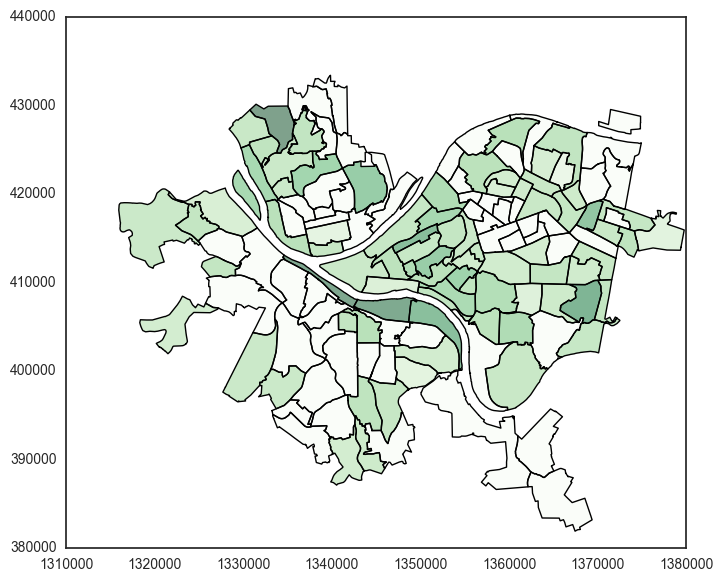

In [49]:
all_metrics = valid_sales.loc[:,['PARID','asmtMrktRatio']]
coords_df = pd.DataFrame(coords.items(), columns=['PARID','ADDR'])

geo_df = pd.merge(coords_df, all_metrics, how='inner', left_on='PARID', right_on='PARID')

#create shapely points from 
geometry = [shapely.geometry.Point(c.longitude, c.latitude) for c in geo_df['ADDR']]
geo_df = gpd.GeoDataFrame(geo_df, crs="+proj=latlon", geometry=geometry)

geo_neigh_metric = gpd.sjoin(geo_df.to_crs(df_neigh.crs), df_neigh[["geometry"]], how="inner", op="within")

# df_neigh.plot(column='mean_asmtMrktRatio', cmap='Greens', figsize=(8,8));

# census tract - more granular than zip code but more aggregated than census block groups for illustration
df_tracts['mean_asmtMrktRatio'] = geo_neigh_metric.groupby("index_right").mean()['asmtMrktRatio']
df_tracts.loc[ pd.isnull(df_tracts['mean_asmtMrktRatio']) == True , 'mean_asmtMrktRatio'] = 0
df_tracts['log_mean_asmtMrktRatio'] = np.log(1 + df_tracts['mean_asmtMrktRatio'])

df_tracts.plot(column='mean_asmtMrktRatio', cmap='Greens', figsize=(8,8));

Residents living in the lightest regions have the lowest property assessments as a percentage of the value of their home. In other words, they are receiving the largest tax break - surely the city would benefit from reassessing the value of their home closer to market value. 

# Train Model on Actual Sale Prices since 2012
Now that we've compared the market values to assessment values for properties where we *know* the recent sale price (since 2012), now we want to build a market value estimator so we can extrapolate this analysis to *every single property in Pittsburgh*, even for properties that have not sold in recenet years. 

# Predict All Unknown Market Values using Trained Model

# Compare Assessment Values to Estimated Market Values for Entire City

# Estimate Property Tax Impact of Any Discrepancies